<a href="https://colab.research.google.com/github/Tim-R413/Cover-Crop-Classification/blob/master/Cover_Crop_Classification_CCT_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Preparation:

In [0]:

% cd /content
%rm -rf Cover-Crop-Classification
#!pwd
!ls

/content
sample_data


# Cover Crop Classification using Tensorflow-Data Preprocessing and Model Framing 




> This is a Google Colab notebook containing the Machine Learning model of an image classfier created to identify species of Cover Crops and more specifically, Canola, Clover, and Triticale.



In [0]:
PIXEL_resolution = 16


##Setup:

In [0]:
# Tensorflow and tf.Keras APIs 
import tensorflow as tf 
from tensorflow import keras
from keras.layers import Dense, Conv2D, Flatten, Activation, Flatten, MaxPooling2D, Dropout
print(tf.__version__)

1.14.0


Using TensorFlow backend.


In [0]:
# Supplementing/ helper Libraries 
import numpy as np 
import matplotlib.pyplot as plt 
import glob 
import os 
import re 
import math

# Python Image Library 
import PIL 
from PIL import Image

Cloning the github repository to obtain image data:

In [0]:
 !git clone   https://github.com/Tim-R413/Cover-Crop-Classification.git

Cloning into 'Cover-Crop-Classification'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 196 (delta 0), reused 0 (delta 0), pack-reused 193
Receiving objects: 100% (196/196), 251.42 MiB | 35.00 MiB/s, done.
Resolving deltas: 100% (79/79), done.
Checking out files: 100% (102/102), done.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#Loading in and Preprocessing the datasets 

##**Define** image preprocessing functions:

REVISED FUNCTIONs that divide images into 9 parts then fill the images and labels dataset arrays 

In [0]:


# define a function that crops each full image into 9 seperate size equivalent images  
def image_division (file_path, photo_size):
  full_img = Image.open(file_path) #.convert('L')
  
   # Make aspect ratio as 1:1, by applying image crop. this converts the images into sqaures
  Width, Height = full_img.size
  if Width != Height:
                m_min_d = min(Width, Height)
                full_img = full_img.crop((0, 0, m_min_d, m_min_d))
  
  # Splits the square image into 5 individual images, each cropped to 1/16 the size of the original image 
  # And Scales the image to the requested max photo size by Anti-alias sampling.
  DF = m_min_d
  DM = math.floor(DF / 4  )
  A = full_img.crop((0, 0, DM, DM)).resize(photo_size, PIL.Image.ANTIALIAS)
  B = full_img.crop((DM,0,2*DM,DM)).resize(photo_size, PIL.Image.ANTIALIAS)
  C = full_img.crop((2*DM,0,3*DM,DM)).resize(photo_size, PIL.Image.ANTIALIAS)
  D = full_img.crop((3*DM,0,DF,DM)).resize(photo_size, PIL.Image.ANTIALIAS)

  E = full_img.crop((0,DM,DM,2*DM)).resize(photo_size, PIL.Image.ANTIALIAS)
  F = full_img.crop((DM,DM,2*DM,2*DM)).resize(photo_size, PIL.Image.ANTIALIAS)
  G = full_img.crop((2*DM,DM,3*DM,2*DM)).resize(photo_size, PIL.Image.ANTIALIAS)
  H = full_img.crop((3*DM,DM,DF,2*DM)).resize(photo_size, PIL.Image.ANTIALIAS)

  I = full_img.crop((0,2*DM,DM,3*DM)).resize(photo_size, PIL.Image.ANTIALIAS)
  J = full_img.crop((DM,2*DM,2*DM,3*DM)).resize(photo_size, PIL.Image.ANTIALIAS)
  K = full_img.crop((2*DM,2*DM,3*DM,3*DM)).resize(photo_size, PIL.Image.ANTIALIAS)
  L = full_img.crop((3*DM,2*DM,DF,3*DM)).resize(photo_size, PIL.Image.ANTIALIAS)

  M = full_img.crop((0,3*DM,DM,DF)).resize(photo_size, PIL.Image.ANTIALIAS)
  N = full_img.crop((DM,3*DM,2*DM,DF)).resize(photo_size, PIL.Image.ANTIALIAS)
  O = full_img.crop((2*DM,3*DM,3*DM,DF)).resize(photo_size, PIL.Image.ANTIALIAS)
  P = full_img.crop((3*DM,3*DM,DF,DF)).resize(photo_size, PIL.Image.ANTIALIAS)


  
  
  
  
  # returns each individual image as its own Numpy arra
  
  return np.asarray(A), np.asarray(B), np.asarray(C), np.asarray(D), np.asarray(E), np.asarray(F), np.asarray(G), np.asarray(H), np.asarray(I), np.asarray(J), np.asarray(K), np.asarray(L), np.asarray(M), np.asarray(N), np.asarray(O), np.asarray(P)

In [0]:
# define a function that maximizes the number of elemaets in a dataset by adding the cropped and scaled smaller images as their own peice of data 
def maximize_image_dataset (dir_path, photo_size):
  images = []
  labels=[]
  os.chdir(dir_path)
  
      # analyzes each image file in the designated folder and uses th eimage_division function to extract 5 seperate images from that larger image
  for file in glob.glob("*.JPG"):
    
        img_A, img_B, img_C, img_D, img_E, img_F, img_G, img_H, img_I, img_J, img_K, img_L, img_M, img_N, img_O, img_P= image_division(file, photo_size)
        img_set = [img_A, img_B, img_C, img_D, img_E, img_F, img_G, img_H, img_I, img_J, img_K, img_L, img_M, img_N, img_O, img_P]
        how_many = len(img_set)
          
        # appends each mini image to the 'images' dataset and appends its respecting index classification label to the 'label' dataset
        # images and labels are appended together so the index is kept consistent between the two datasets.  
        if re.match('Canola*', file) or re.match('.*canola*', file):
                 for i in range (0,how_many):
                    images.append(img_set[i])
                    labels.append(0)
                               
        elif re.match('Clover*', file) or re.match('.*clover*', file):
                 for i in range (0,how_many):
                       images.append(img_set[i])
                       labels.append(1)
                    
        elif re.match('Triticale*', file) or re.match('.*triticale*', file):
                 for i in range (0,how_many):
                        images.append(img_set[i])
                        labels.append(2)
                    
       # same as above section, was made to account for images with the lowercase '.jpg' extension         
  for file in glob.glob("*.jpg"):
    
        img_A, img_B, img_C, img_D, img_E, img_F, img_G, img_H, img_I, img_J, img_K, img_L, img_M, img_N, img_O, img_P= image_division (file, photo_size)
        img_set = [img_A, img_B, img_C, img_D, img_E, img_F, img_G, img_H, img_I, img_J, img_K, img_L, img_M, img_N, img_O, img_P]
        how_many = len(img_set)
          
        if re.match('Canola*', file) or re.match('.*canola*', file):
              for i in range (0,how_many):
                    images.append(img_set[i])
                    labels.append(0)
                               
        elif re.match('Clover*', file) or re.match('.*clover*', file):
                for i in range (0,how_many):
                       images.append(img_set[i])
                       labels.append(1)
                    
        elif re.match('Triticale*', file) or re.match('.*triticale*', file):
                for i in range (0,how_many):
                       images.append(img_set[i])
                       labels.append(2)
                
  return (images,labels)

In [0]:
# Define a function that shuffles np arrays in unison to keep image and label index consistent:
def unison_shuffled_copies(I, L):
    assert len(I) == len(L)
    p = np.random.permutation(len(I))
    return I[p], L[p]

##Define image size and conduct dataset creation 

In [0]:
# image pixel resolution used to train and test model
a=PIXEL_resolution
photo_size= a, a
%cd /content

/content


In [0]:
# speciescategories or labels are indexed as following: 
#Canola:0 
#Clover:1 
#Triticale:2 

CATEGORIES = ['Canola', 'Clover', 'Triticale']
category_to_index = dict((name, index) for index,name in enumerate (CATEGORIES))
category_to_index


{'Canola': 0, 'Clover': 1, 'Triticale': 2}

In [0]:
## load training and test data into numpy aarrays by executing these functions:

(images, labels) = maximize_image_dataset("/content/Cover-Crop-Classification/COVER CROP DATASET",photo_size)
(more_images,more_labels) = maximize_image_dataset('/content/gdrive/My Drive/Cover Crop species data /HALF SPECIES DATA',photo_size)
images.extend(more_images)
labels.extend(more_labels)
images=np.asarray(images)
labels=np.asarray(labels)

In [0]:
#Check shape and size of the dataset arrays
print(len(images))
print(len(labels))

print (images.shape)


1136
1136
(1136, 16, 16, 3)


randomly shuffle image and label data arrays, consistent with eachother. 

In [0]:
print('Original order of images/labels: \n' ,  labels)
images, labels = unison_shuffled_copies(images, labels)
print ()
print('Shuffled order of images/labels: \n' , labels)

Original order of images/labels: 
 [0 0 0 ... 2 2 2]

Shuffled order of images/labels: 
 [1 1 1 ... 0 1 0]


Seperate the full array of images and labels into 90% training data and 10% validation data 

In [0]:
## normalize the data
images=images/255.0


## Validating and displaying original datasets 

In [0]:
print(labels)

[1 1 1 ... 0 1 0]


In [0]:
def display_images(images, labels):
        plt.figure(figsize=(15,15))
        grid_size = min(16, len(images))
        for i in range(grid_size):
                plt.subplot(4, 4, i+1)
                plt.xticks([])
                plt.yticks([])
                plt.grid(False)
                plt.imshow(images[i], cmap=plt.cm.binary)
                plt.xlabel(CATEGORIES[labels[i]])

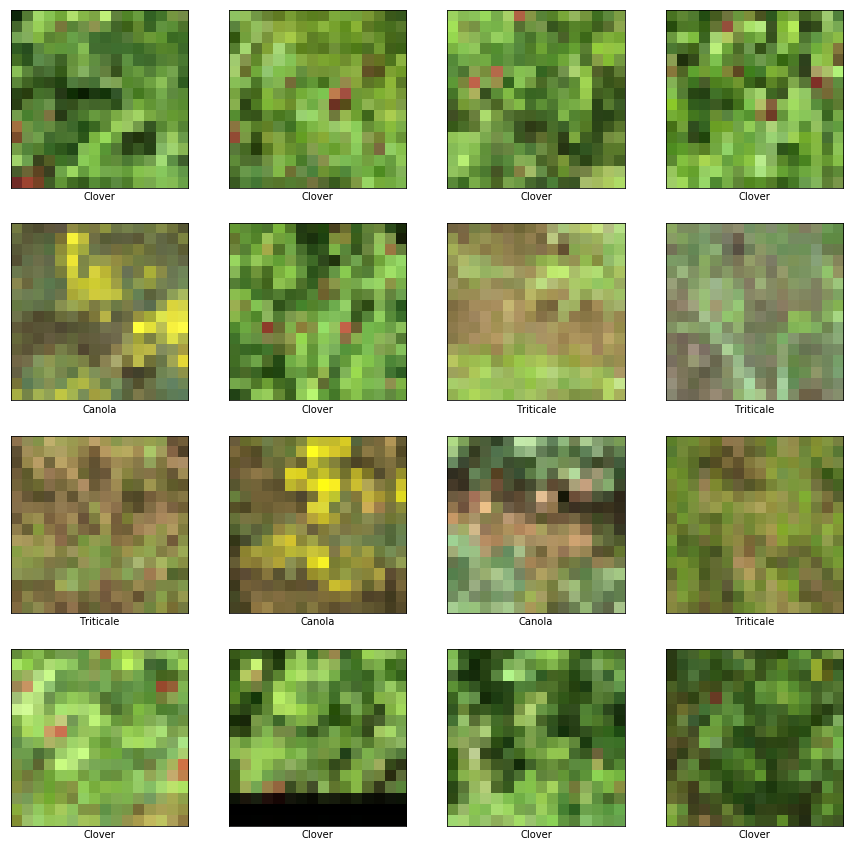

In [0]:
display_images(images, labels)
plt.show()

Text(0.5, 0, 'Clover')

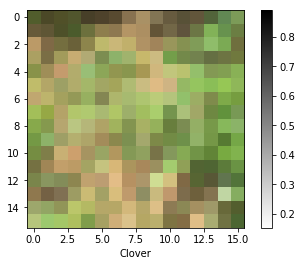

In [0]:
subtitle = 112
plt.figure()
plt.imshow(images[subtitle], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.xlabel(CATEGORIES[labels[subtitle]])

#Building the ML model:

**Initiialize the model layers:**

### Different model builds:

In [0]:
MarkI_model = keras.Sequential([
  keras.layers.Flatten(input_shape = (a, a, 3)),
 keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dropout(0.25),
 keras.layers.Dense(50, activation=tf.nn.relu),
  keras.layers.Dense(3, activation=tf.nn.softmax)])

W0723 17:25:51.496170 140494730393472 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
MarkII_model = keras.Sequential([
  keras.layers.Flatten(input_shape = (a, a, 3)),
 keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dropout(0.25),
 keras.layers.Dense(64, activation=tf.nn.relu),
  keras.layers.Dense(3, activation=tf.nn.softmax)])

In [0]:
MarkIV_CNN_model = keras.Sequential([
  
  keras.layers.Conv2D(filters=32, kernel_size=3,padding='same', activation= 'relu', input_shape=(a,a,3)),
  (keras.layers.MaxPooling2D(pool_size=(2,2))),
  (tf.keras.layers.Dropout(0.3)),
  
  (keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same', activation=tf.nn.relu)),
  (keras.layers.MaxPooling2D(pool_size = (2,2))),
  (keras.layers.Dropout(0.5)),
  
 (keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same', activation=tf.nn.relu)),
 (keras.layers.MaxPooling2D(pool_size = (2,2))),
  (keras.layers.Dropout(0.5)),
  
  
  (keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding='same', activation=tf.nn.relu)),
  (keras.layers.MaxPooling2D(pool_size = (2,2))),
 (keras.layers.Dropout(0.5)),
  
  (keras.layers.Flatten()),
(keras.layers.Dense(256,activation=tf.nn.relu)),
  (tf.keras.layers.Dropout(0.5)),
    keras.layers.Dense(128,activation='relu'),
    (tf.keras.layers.Dropout(0.25)),
  
(keras.layers.Dense(3, activation=tf.nn.softmax))])

**Compile the model:**

In [0]:

# which model will be tested 
run_model = MarkIV_CNN_model



In [0]:
MarkI_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
MarkII_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
run_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training :

In [0]:
MarkI_model.fit(images,labels, validation_split=0.10, shuffle=True, epochs =75)

Train on 1022 samples, validate on 114 samples
Epoch 1/75
1022/1022 [==============================] - 1s 1ms/sample - loss: 1.0957 - acc: 0.4061 - val_loss: 1.0391 - val_acc: 0.3860
Epoch 2/75
1022/1022 [==============================] - 0s 128us/sample - loss: 1.0026 - acc: 0.4873 - val_loss: 0.9182 - val_acc: 0.5789
Epoch 3/75
1022/1022 [==============================] - 0s 129us/sample - loss: 0.8922 - acc: 0.5577 - val_loss: 0.8263 - val_acc: 0.5965
Epoch 4/75
1022/1022 [==============================] - 0s 116us/sample - loss: 0.7800 - acc: 0.6135 - val_loss: 0.7781 - val_acc: 0.5702
Epoch 5/75
1022/1022 [==============================] - 0s 118us/sample - loss: 0.7235 - acc: 0.6233 - val_loss: 0.8100 - val_acc: 0.6140
Epoch 6/75
1022/1022 [==============================] - 0s 142us/sample - loss: 0.7187 - acc: 0.6272 - val_loss: 0.7949 - val_acc: 0.6404
Epoch 7/75
1022/1022 [==============================] - 0s 114us/sample - loss: 0.6880 - acc: 0.6458 - val_loss: 0.7487 - val_a

In [0]:
MarkII_model.fit(images,labels, validation_split=0.10, shuffle=True, epochs =75)

Train on 1022 samples, validate on 114 samples
Epoch 1/75
1022/1022 [==============================] - 0s 275us/sample - loss: 1.1315 - acc: 0.4022 - val_loss: 1.0709 - val_acc: 0.3596
Epoch 2/75
1022/1022 [==============================] - 0s 128us/sample - loss: 1.0190 - acc: 0.4618 - val_loss: 0.9383 - val_acc: 0.6140
Epoch 3/75
1022/1022 [==============================] - 0s 117us/sample - loss: 0.8884 - acc: 0.5656 - val_loss: 0.8141 - val_acc: 0.5965
Epoch 4/75
1022/1022 [==============================] - 0s 133us/sample - loss: 0.7898 - acc: 0.5910 - val_loss: 0.7599 - val_acc: 0.6754
Epoch 5/75
1022/1022 [==============================] - 0s 134us/sample - loss: 0.7157 - acc: 0.6389 - val_loss: 0.7317 - val_acc: 0.5789
Epoch 6/75
1022/1022 [==============================] - 0s 130us/sample - loss: 0.6834 - acc: 0.6712 - val_loss: 0.7197 - val_acc: 0.6053
Epoch 7/75
1022/1022 [==============================] - 0s 125us/sample - loss: 0.6756 - acc: 0.6477 - val_loss: 0.7191 - val

In [0]:

history=run_model.fit(images,labels, validation_split=0.10, shuffle=True, epochs =75)

Train on 1022 samples, validate on 114 samples
Epoch 1/75
1022/1022 [==============================] - 3s 3ms/sample - loss: 1.1053 - acc: 0.3474 - val_loss: 1.0972 - val_acc: 0.4298
Epoch 2/75
1022/1022 [==============================] - 0s 268us/sample - loss: 1.0991 - acc: 0.3464 - val_loss: 1.0959 - val_acc: 0.4386
Epoch 3/75
1022/1022 [==============================] - 0s 265us/sample - loss: 1.0939 - acc: 0.3620 - val_loss: 1.0883 - val_acc: 0.4737
Epoch 4/75
1022/1022 [==============================] - 0s 264us/sample - loss: 1.0381 - acc: 0.4569 - val_loss: 0.9456 - val_acc: 0.5614
Epoch 5/75
1022/1022 [==============================] - 0s 263us/sample - loss: 0.7866 - acc: 0.5822 - val_loss: 0.9018 - val_acc: 0.4912
Epoch 6/75
1022/1022 [==============================] - 0s 276us/sample - loss: 0.6920 - acc: 0.6292 - val_loss: 0.7275 - val_acc: 0.5877
Epoch 7/75
1022/1022 [==============================] - 0s 261us/sample - loss: 0.7183 - acc: 0.5969 - val_loss: 0.7357 - val_a

### Plot Training Results:

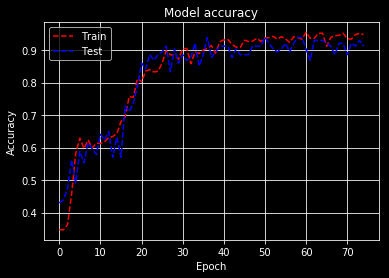

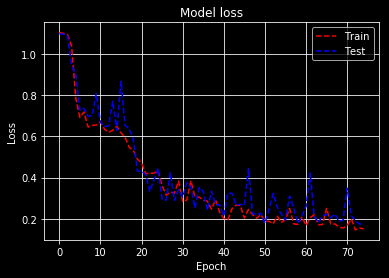

In [0]:

plt.style.use('dark_background')
# Plot training & validation accuracy values
plt.plot(history.history['acc'],'r--',history.history['val_acc'],'b--')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.grid()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'],'r--',history.history['val_loss'],'b--')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.grid()
plt.show()

#Saving the Model(s)

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
tf.keras.models.save_model(
   MarkI_model,
  '/content/gdrive/My Drive/MarkI_model',
   overwrite=True,
    include_optimizer=True,
    save_format=None
)

In [0]:
tf.keras.models.save_model(
   MarkII_model,
  '/content/gdrive/My Drive/MarkII_model',
   overwrite=True,
    include_optimizer=True,
    save_format=None
)

In [0]:
tf.keras.models.save_model(
   MarkIV_CNN_model,
  '/content/gdrive/My Drive/MarkIV_CNN_model',
   overwrite=True,
    include_optimizer=True,
    save_format=None
)

In [0]:
print('THE END')

THE END
